<a href="https://colab.research.google.com/github/dongchanlim/CS450/blob/master/game_sale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from google.colab import files

file = files.upload()

Saving Video_Games_Sales_as_at_22_Dec_2016.csv to Video_Games_Sales_as_at_22_Dec_2016.csv


In [4]:
game_sale = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv", na_values= ["NaN"])

In [5]:
game_sale.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
game_sale.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

In [7]:
game_sale.isnull().sum(axis = 0) / game_sale.shape[0] * 100 

Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64

In [8]:
game_sale.shape

(16719, 16)

In [9]:
# cut out columns which has 40 % missing portion and name columns which only stands for name.
# game_sale.columns = game_sale.columns - ["Critic_Score", "Critic_Count", "User_Score", "User_Count", "Developer", "Rating", "Name"]
game_sale = game_sale.drop(columns = ["Critic_Score", "Critic_Count", "User_Score", "User_Count", "Developer", "Rating", "Name"])
game_sale.isnull().sum(axis = 0) / len(game_sale)

Platform           0.000000
Year_of_Release    0.016089
Genre              0.000120
Publisher          0.003230
NA_Sales           0.000000
EU_Sales           0.000000
JP_Sales           0.000000
Other_Sales        0.000000
Global_Sales       0.000000
dtype: float64

In [10]:
game_sale.shape

(16719, 9)

In [11]:
# change the Year_of_Relase as categorical data

game_sale.Year_of_Release = game_sale.Year_of_Release.astype("category").cat.codes

In [12]:
# Impute missing value by filling most frequent case

from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy = "most_frequent")

game_sale[["Year_of_Release","Genre","Publisher"]] = si.fit_transform(game_sale[["Year_of_Release","Genre","Publisher"]])

In [13]:
game_sale.isnull().sum(axis = 0)

Platform           0
Year_of_Release    0
Genre              0
Publisher          0
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
dtype: int64

In [14]:
# train/test split 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = game_sale.drop(columns = ["Global_Sales"], axis = 1)
y = game_sale.Global_Sales

# Standardization of numeric data
std = StandardScaler()
num_col = X.select_dtypes("number").columns
X[num_col] = std.fit_transform(X[num_col])

# One-Hot-Encoding of categorical data
X = pd.get_dummies(X)


train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [15]:
train_X.shape

(11703, 629)

In [16]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 629, kernel_initializer='normal'))
model.add(layers.Dense(16, activation='relu', kernel_initializer='normal'))
model.add(layers.Dense(1, activation='linear', kernel_initializer='normal'))

Using TensorFlow backend.


In [17]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [18]:
# training outcome 
model.fit(train_X, train_y, epochs=5, batch_size = 32)

Epoch 1/5
11703/11703 [==============================] - 2s 131us/step - loss: 0.3815
Epoch 2/5
11703/11703 [==============================] - 1s 113us/step - loss: 0.0074
Epoch 3/5
11703/11703 [==============================] - 1s 111us/step - loss: 0.0024
Epoch 4/5
11703/11703 [==============================] - 1s 107us/step - loss: 0.0033
Epoch 5/5
11703/11703 [==============================] - 1s 109us/step - loss: 7.0698e-04


In [19]:
# show the validation outcome (accuracy) using test_X and test_y
history = model.fit(train_X, train_y, epochs= 5, validation_data= (test_X, test_y), batch_size= 32)

Train on 11703 samples, validate on 5016 samples
Epoch 1/5
11703/11703 [==============================] - 1s 125us/step - loss: 0.0014 - val_loss: 9.8853e-04
Epoch 2/5
11703/11703 [==============================] - 1s 124us/step - loss: 0.0057 - val_loss: 0.0031
Epoch 3/5
11703/11703 [==============================] - 1s 127us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 4/5
11703/11703 [==============================] - 1s 124us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/5
11703/11703 [==============================] - 1s 123us/step - loss: 0.0220 - val_loss: 0.0175


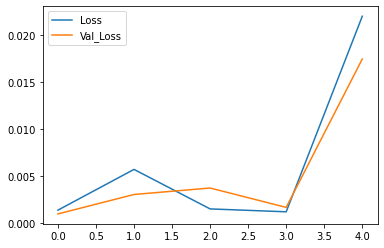

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val_Loss")
plt.legend()

In [21]:
# hyperparameter grid_search
from sklearn.model_selection import GridSearchCV

param_grid = dict(epochs=[10,20,30,40], batch_size = [2**i for i in range(5,9)])
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs= -1, cv = 5)
grid_result = grid.fit(train_X, train_y)

TypeError: ignored

In [22]:
import sklearn.metrics

sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']